# Library
The library implements C++ functions bindend in Python with Pybind11. A pure python counterpart is avaliable at excursion_set_function.python.

# 1. Integration functions

In [1]:
import numpy as np
from excursion_set_functions import integration
from excursion_set_functions.python import integration as int_py
import matplotlib.pyplot as plt
import pandas

#read Pk
k_Pk = pandas.read_csv('LCDM_matterpower.dat',sep='\s+', header=0).values
k = k_Pk[:,0]
Pk = k_Pk[:,1]

/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Compute $C_{i,j} = \langle \delta(R_i) \delta(R_j) \rangle = \int \frac{{\rm d} k \, k^2}{2 \pi^2} P(k) W(kR_i) W^*(kR_j)$ matrix for top-hat filter, $W(kR) = 3 j_1(kR)/kR$, where $j_1(x)=(\sin x - x \cos x)/x^2$ is the spherical Bessel function of order 1.
The pure python integration functions are quite slow, as they require the usage of scipy.special, which cannot be accelerated with numba. A parallelization with multiprocessing is even slower.

C++ vs python max rel. err.:
    Cij: 2.684612310233092e-09
    s:   1.1108891584399316e-12
    s22: 1.0369587870817654e-05
    dsdR: 3.4308111906966587e-12
    DW: 1.0369592084558121e-05


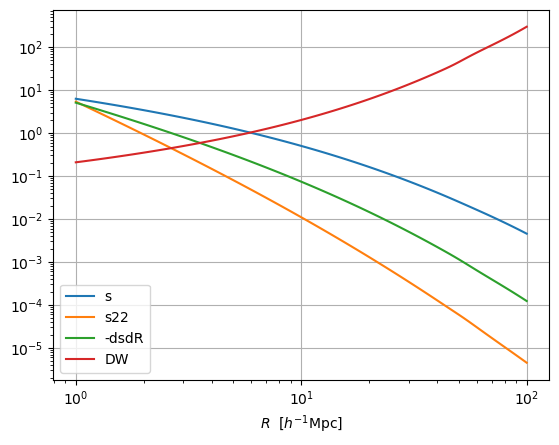

In [2]:
R = np.logspace(2,0,101) #R must be decreasing for numerical excursion-set functions
Cij = int_py.C_ij_TopHat(Pk,k,R)
Cij_cpp = integration.C_ij_TopHat(Pk,k,R)
print('C++ vs python max rel. err.:\n    Cij:',np.max(np.abs(Cij/Cij_cpp-1)))

# S is the diagonal of Cij
s = int_py.sigma2_TopHat(Pk,k,R)
s_cpp = integration.sigma2_TopHat(Pk,k,R)
print('    s:  ',np.max(np.abs(s/s_cpp-1)))
    
s22 = int_py.sigma2_2_TopHat_numdiff(Pk,k,R)
s22_cpp = integration.sigma2_2_TopHat_numdiff(Pk,k,R)
print('    s22:',np.max(np.abs(s22/s22_cpp-1)))
    
dsdR = int_py.dSdR_TopHat(Pk,k,R)
dsdR_cpp = integration.dSdR_TopHat(Pk,k,R)
print('    dsdR:',np.max(np.abs(dsdR/dsdR_cpp-1)))

DW = s22 / dsdR ** 2
DW_cpp = s22_cpp / dsdR_cpp ** 2
print('    DW:',np.max(np.abs(DW/DW_cpp-1)))

plt.plot(R,s,label='s')
plt.plot(R,s22,label='s22')
plt.plot(R,-dsdR,label='-dsdR')
plt.plot(R,DW,label='DW')
plt.loglog()
plt.grid()
plt.xlabel('$R$  [$h^{-1}$Mpc]')
plt.legend()
plt.show()



# 2. Numerical and analytical multiplicity functions

compiling numba...
    done.
numba running time: 1.3926844596862793
cpp running time: 1.191711664199829


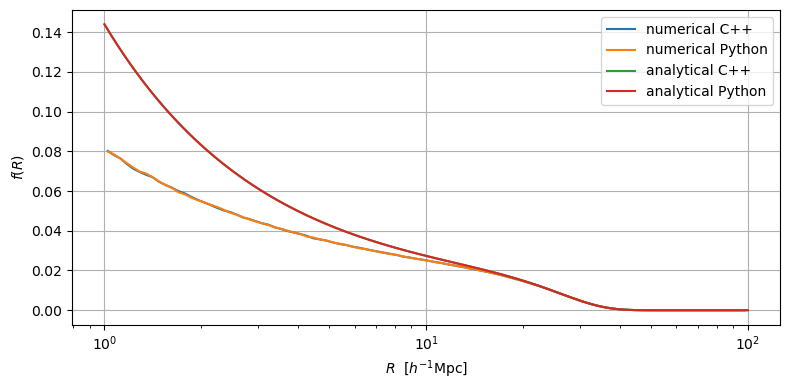

In [3]:
from excursion_set_functions import numerical
from excursion_set_functions import analytical
from excursion_set_functions.python import numerical as num_py
from excursion_set_functions.python import analytical as f_an_py
import time


Npaths = int(1e7) # number of random-walk realization

#Moving barrier
delta_v_lin = -0.8
alpha = 0.517*abs(delta_v_lin) - 0.089
beta = 0.098*abs(delta_v_lin) + 0.103
gamma = 0.87
params_B = [alpha,beta,gamma]
B = params_B[0] * (1. + (params_B[1]/s**0.5)**params_B[2])
dB_ds = -0.5*params_B[0]*params_B[1]**params_B[2]*params_B[2] * s **(-params_B[2]/2.-1)
#Cholenski decomposizion of Cij, linearized
Lij = int_py.cholensky_decomposition_matrix_from_Cij(Cij)

# number of paths that first crossess the barrier between R[i] and R[i+1]
print('compiling numba...')
Ncross = num_py.first_crossing_single_barrier(Lij, 100, B)
print('    done.')
t0 = time.time()
Ncross = num_py.first_crossing_single_barrier(Lij, Npaths, B)
dt = time.time() - t0
print('numba running time:',dt)

t0 = time.time()
Ncross_cpp = numerical.first_crossing_single_barrier(Lij, Npaths, B)
dt = time.time() - t0
print('cpp running time:',dt)

    

#numerical multiplicity function f(R): differantial fraction of random-walks that first crosses the barrier between R and R+dR
# (R is decreasing)
dR = R[:-1] - R[1:]
Rmean = 0.5 * (R[:-1] + R[1:])
f_num_R = Ncross[1:] / Npaths / dR
f_num_R_cpp = Ncross_cpp[1:] / Npaths / dR

# corresponding analytical approximation:

f_appr_R = f_an_py.f_S_MB_approx(s,DW,B,dB_ds) * np.abs(dsdR)

f_appr_R_cpp = analytical.f_S_MB_approx(s,DW,B,dB_ds) * np.abs(dsdR)


fig = plt.figure(figsize=[8,4])
plt.plot(Rmean,f_num_R_cpp,label='numerical C++')
plt.plot(Rmean,f_num_R,label='numerical Python')
plt.plot(R,f_appr_R_cpp,label='analytical C++')
plt.plot(R,f_appr_R,label='analytical Python')
plt.semilogx()
plt.grid()
plt.legend()
plt.ylabel('$f(R)$')
plt.xlabel('$R$  [$h^{-1}$Mpc]')
fig.tight_layout()



Void size function

Spherical Eulerian mapping: delta_lin = -0.8 , delta_v_NL =  -0.4775527219109863


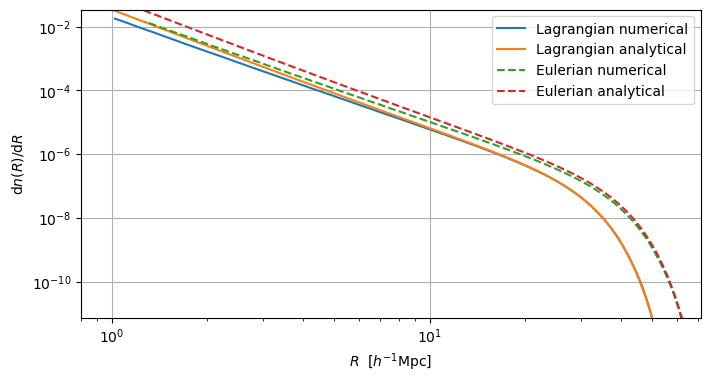

In [4]:
VSF_num_L = 3. / (4. * np.pi * Rmean**3) * f_num_R
VSF_approx_L = 3. / (4. * np.pi * R**3) * f_appr_R

#spherical Eulerian mapping:
from excursion_set_functions.utilities import delta_NL_underdensity
delta_v_NL = delta_NL_underdensity(delta_v_lin)
expansion_factor = (1.+delta_v_NL)**(-1./3.)
Rmean_E = Rmean * expansion_factor
R_E = R * expansion_factor
VSF_num_E = (3. / (4. * np.pi * Rmean **3) * f_num_R) / expansion_factor
VSF_approx_E = (3. / (4. * np.pi * R **3) * f_appr_R) / expansion_factor

print('Spherical Eulerian mapping: delta_lin =',delta_v_lin,', delta_v_NL = ',delta_v_NL)

fig = plt.figure(figsize=[8,4])
plt.plot(Rmean,VSF_num_L,label='Lagrangian numerical')
plt.plot(R,VSF_approx_L,label='Lagrangian analytical')
plt.plot(Rmean_E,VSF_num_E,label='Eulerian numerical',ls='--')
plt.plot(R_E,VSF_approx_L,label='Eulerian analytical',ls='--')
plt.loglog()
plt.grid()
plt.legend()
plt.xlim(0.8,(R[1:])[f_num_R==0][-1]*expansion_factor)
plt.ylim(VSF_approx_L[15],VSF_approx_L[-1])
plt.ylabel('${\\rm d} n(R) / {\\rm d} R$')
plt.xlabel('$R$  [$h^{-1}$Mpc]')
plt.show()

# Void density profile
In the current version, this function is implemented in pure python only

In [5]:
delta_min,delta_max,nbins = -2.,2,50 #max val, min val, nbins for histogram
NumCrossing, FiltPath_mean, histo_bins, hist_dict = num_py.first_crossing_profile_single_barrier(
    Lij, Npaths, B,delta_min,delta_max,nbins)
# NumCrossing: first crossing 
# FiltPath_mean: (len(B),len(B)) array. FiltPath_mean[:,i] = mean random-walk crossing first crossing the barrier between B[i-1] and B[i]
# histo_bins: bins for the histogram, np.linspace(delta_min,delta_max,nbins+1)
# hist_dict: numba dict of (nbins,len(B)) arrays. hist_dict[i][:,j] = histogram of random-walk values at j, for random walks that cross the barrier between B[i-1] and B[i]


(101, 101) 10.0 (50, 101) [-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


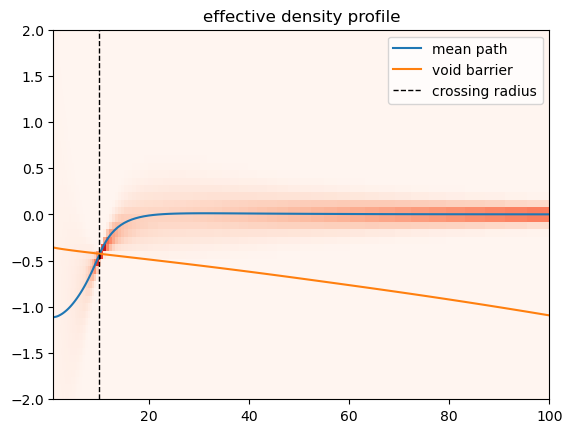

In [6]:
print(FiltPath_mean.shape,R[50],hist_dict[50].shape,histo_bins)
iR = 50
# the minus sign is beacause we compute all absolute quantities that shuld be converted in underdensities
plt.pcolormesh(R,-histo_bins,hist_dict[iR][:,1:],cmap=plt.cm.Reds)
plt.plot(R,-FiltPath_mean[:,iR],label='mean path')
plt.plot(R,-B,label='void barrier')
plt.axvline(R[iR],ls='--',c='k',lw=1,label='crossing radius')
plt.title('effective density profile')
plt.legend()
plt.show()

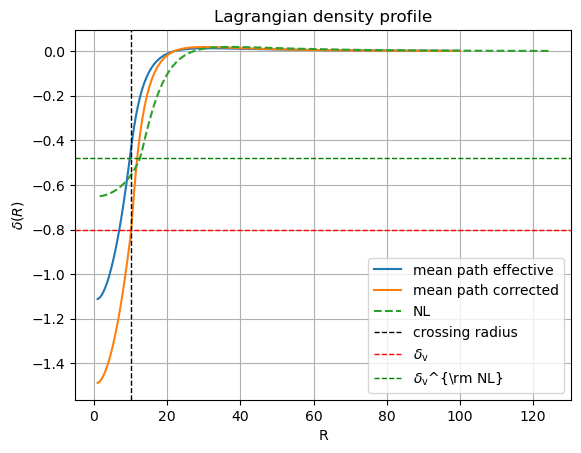

In [12]:
from excursion_set_functions.utilities import delta_NL_from_lin

mean_path_corr = -FiltPath_mean[:,iR]
mean_path_corr[:iR] *= -delta_v_lin/B[:iR]
mean_path_corr[iR:] += delta_v_lin + B[iR]


plt.plot(R,-FiltPath_mean[:,iR],label='mean path effective')
plt.plot(R,mean_path_corr,label='mean path corrected')
plt.plot(R*expansion_factor,delta_NL_from_lin(mean_path_corr),label='NL',ls='--')
plt.axvline(R[iR],ls='--',c='k',lw=1,label='crossing radius')
plt.axhline(delta_v_lin,ls='--',c='r',lw=1,label='$\delta_{\\rm v}$')
plt.axhline(delta_NL_from_lin(delta_v_lin),ls='--',c='g',lw=1,label='$\delta_{\\rm v}$^{\\rm NL}')
plt.title('Lagrangian density profile')
plt.legend()
plt.xlabel('R')
plt.ylabel('$\delta(R)$')
plt.grid()
plt.show()